In [27]:
import sys
import torch
torch.cuda.empty_cache()
import torch.nn as nn
print(sys.version)
print("----------------")
print("torch.cuda.is_available: ",torch.cuda.is_available())
import scipy.io as spio
from Plotting_class import add_colorbar
from Plotting_class import imagesc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
----------------
torch.cuda.is_available:  True


# Demo code for the implicit full waveform inversion (IFWI)

## The basic methodology of the IFWI: 
### Instead of directly updating the elastic models, we define the neural network (NN), which generates the elastic models, and optimize the weights in NN. 

<img src="IFWI_fig.PNG" width="50%">

### Major advantage: 
##### IFWI reduce the dependence on the explicit accurate initial models like in the conventional FWI. The initial model for IFWI is randomly generated according to prior information.


### Refereneces:
##### (1) "Implicit Seismic Full Waveform Inversion With Deep Neural Representation", Jian Sun, Kristopher Innanen, Tianze Zhang, and Daniel Trad, Journal of Geophysical Research: Solid Earth, e2022JB025964

##### (2) "Multilayer Perceptron and Bayesian Neural Network-Based Elastic Implicit Full Waveform Inversion", T. Zhang, J. Sun, D. Trad and K. Innanen, IEEE Transactions on Geoscience and Remote Sensing, vol. 61, pp. 1-16, 2023

# Step 1: Observed data generating

In [28]:
# importing the true models for vp, vs and denisty, which are part of the Marmousi model
vp0 = spio.loadmat('./Mar_ori_vp.mat', squeeze_me=True)
vp0_true = vp0['data_vp']
vp0_true = torch.from_numpy(np.array(vp0_true, dtype=np.float64))
vp0_true = torch.as_tensor(vp0_true)
[nz, nx] = [vp0_true.shape[0],vp0_true.shape[1]]

sparse_x = 8
sparse_z = 30

nnz = np.arange(0,nz,sparse_x).tolist()
nnx = np.arange(0,nx,sparse_z).tolist()
vp0_true = vp0_true[nnz,:]; vp0_true=vp0_true[:,nnx]
[nz, nx] = [vp0_true.shape[0],vp0_true.shape[1]]

c1 =50; c2=130;
c3 =1;  c4=200;
vs0 = spio.loadmat('./Mar_ori_vs.mat', squeeze_me=True)
vs0_true = vs0['data_vs']
vs0_true = torch.from_numpy(np.array(vs0_true, dtype=np.float64))
vs0_true = torch.as_tensor(vs0_true)
[nz, nx] = [vs0_true.shape[0],vs0_true.shape[1]]


vs0_true = vs0_true[nnz,:]; vs0_true=vs0_true[:,nnx]
[nz, nx] = [vs0_true.shape[0],vs0_true.shape[1]]

vs0_true = vs0_true[c1:c2,c3:c4]
vs_tensor = vs0_true+1500

rho0 = spio.loadmat('./Mar_ori_rho.mat', squeeze_me=True)
rho0_true = rho0['data_rho']
rho0_true = torch.from_numpy(np.array(rho0_true, dtype=np.float64))
rho0_true = torch.as_tensor(rho0_true)
[nz, nx] = [rho0_true.shape[0],rho0_true.shape[1]]

nnz = np.arange(0,nz,sparse_x).tolist()
nnx = np.arange(0,nx,sparse_z).tolist()
rho0_true = rho0_true[nnz,:]; rho0_true=rho0_true[:,nnx]
[nz, nx] = [rho0_true.shape[0],rho0_true.shape[1]]

rho0_true = rho0_true[c1:c2,c3:c4]
rho_tensor = rho0_true*1000


dx0=20
dz0=20


vp0_true = vp0_true[c1:c2,c3:c4]
vp_tensor = vp0_true+1400


In [29]:
[nz, nx] = [vp_tensor.shape[0],vp_tensor.shape[1]]

dx0 =20
dz0 =20

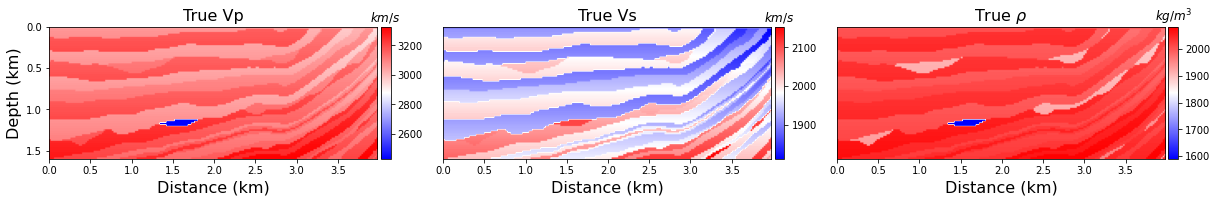

In [50]:
font_size = 16
color_bar = 'bwr'



fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"True Vp", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"True Vs", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_yticks([])

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')
ax.set_title(r"True $\rho$", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_yticks([])
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

In [51]:
#importing the forward modeling engine, RNN-based method, defining the acquisition system, and genertate the observed data
from rnn_fd_elastic2 import rnn2D
from generator import wGenerator
sample_interval = 30
freeSurface = False                                                    # free surface option for forward modeling
npad = 10                                                              # velocity padding in grid points
freq = 5.0                                                             # dominant frequency of wavelet in Hz
dt = 0.002                                                             # time samling interval, fixed for all shots gathers
nt = 1000                                                              # number of samples in time

#defining the sources locations on the computational grid
xs = np.arange(2,nx,30,dtype=np.int32) # source x-coordinate
zs = np.ones(xs.shape, dtype=np.int32) # source z-coordinate
#defining the receivors locations on the computational grid
xr = np.arange(0,nx, 1, dtype=np.int32) # receiver x-coordinate
zr = np.ones(xr.shape, dtype=np.int32) # receiver z-coordinate


#defining the sources wave let
t = dt * torch.arange(0, nt, dtype=torch.float32)                                # create time vector
wavelet = wGenerator(t, freq).ricker().to(device)*10000000                       # generate wavelet


#defining the grid length of the computational grid
dx = 20
dz = 20


#send tensor to gpu device, for GPU acceleration 
vp_tensor = torch.reshape(vp_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
vs_tensor = torch.reshape(vs_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
rho_tensor = torch.reshape(rho_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)

# define the object according to the rnn2D class
forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=2, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)

# Using this object to perfrom the forward modeling obtaining the observed data
vx_save, vz_save, \
txx_save, tzz_save, txz_save, \
segment_ytPred_x,segment_ytPred_z,avg_regularizer,\
vp_tensor_out,vs_tensor_out,rho_tensor_out = \
forward_rnn(vp_tensor=vp_tensor.to(device),\
            vs_tensor=vs_tensor.to(device),\
            rho_tensor=rho_tensor.to(device),\
            segment_wavelet=wavelet)

shots= torch.cat((segment_ytPred_x.reshape(1, len(xs),len(t), len(xr)),\
                  segment_ytPred_z.reshape(1, len(xs),len(t), len(xr))),dim=0)
print(shots.shape)

torch.Size([2, 7, 1000, 199])


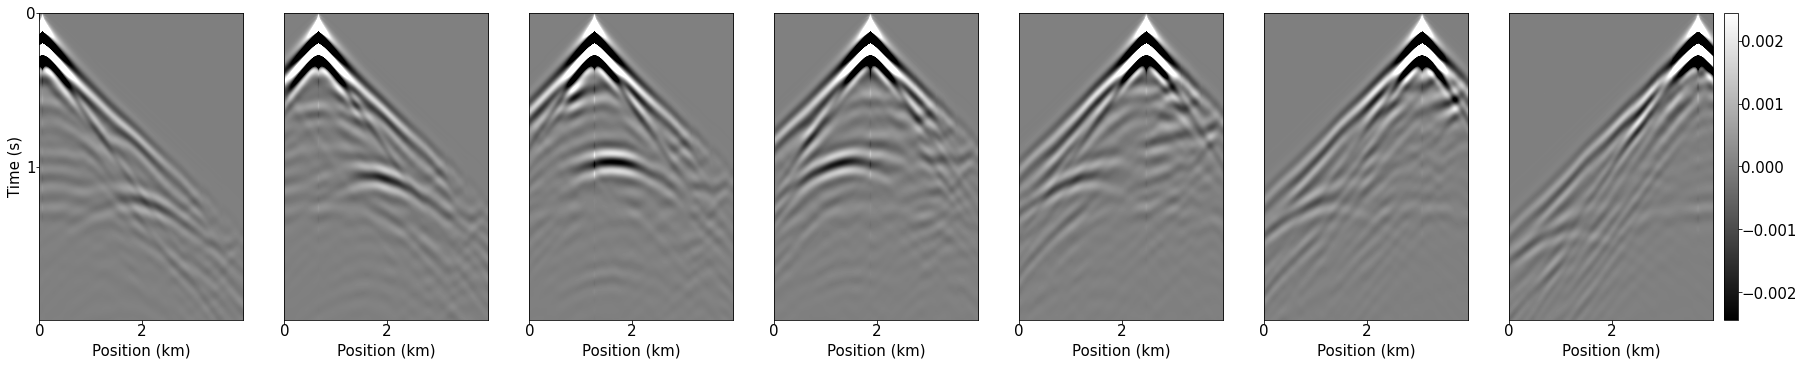

In [52]:
fig=plt.figure(figsize=(30, 10))
imagesc(fig,
        segment_ytPred_z.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/100,
        vmax=segment_ytPred_z.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=3, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=15,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')
#fig.tight_layout(pad=-.05)

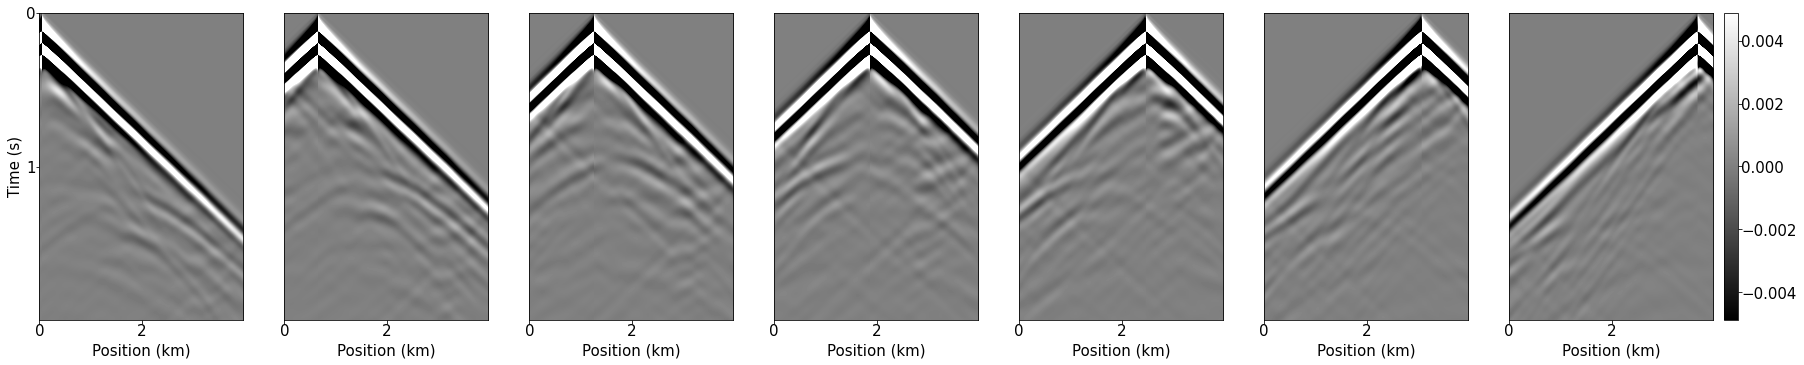

In [53]:
fig=plt.figure(figsize=(30, 10))
imagesc(fig,
        segment_ytPred_x.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/50,
        vmax=segment_ytPred_z.max()/50,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=3, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=15,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')
#fig.tight_layout(pad=-.05)

# Step two: IFWI 

In [55]:
# obtaining the well log information for the vp, vs, and density , i.e., the mean and the std for each parameter
well_index = 55
std_scale = 1
vp_well = vp_tensor[:,:,well_index]
vs_well = vs_tensor[:,:,well_index]
rho_well = rho_tensor[:,:,well_index]

In [12]:
from MLP_based_IFWI_2 import IFWI2D
"""
Args:
    segment_size            (int)        ---- the total discrete  number of t
    mean1,                  (float32)    ---- vp mean obtained from well log                         
    std1,                   (float32)    ---- vp std obtained from well log     
    mean2,                  (float32)    ---- vs mean obtained from well log
    std2,                   (float32)    ---- vs std obtained from well log
    mean3,                  (float32)    ---- rho mean obtained from well log
    std3,                   (float32)    ---- rho std obtained from well log
    std_scale,              (float32)    ---- scaling the std in case of the well log does not well represent the target area
    neuron,                 (list of int)---- defining the number of neurons of each NN later
    omega_0,                (float32)    ---- influencing the initialization of the weights        
    activation,             (string)     ---- defining the activation functions of the neural network
    bias,                   (Boolean)    ---- if bias is included in the neural network
    outermost_linear,       (Boolean)    ---- if True, then not activation function is applied on the last layer.
    ns,                     (float32)    ---- total number of the shots
    nz,                     (float32)    ---- total number of the grid points in z direction 
    nx,                     (float32)    ---- total number of the grid points in x direction 
    zs,                     (float32)    ---- shots positions in the z direction on the computational grid
    xs,                     (float32)    ---- shots positions in the x direction on the computational grid
    zr,                     (float32)    ---- receiver positions in the z direction on the computational grid
    xr,                     (float32)    ---- receiver positions in the x direction on the computational grid
    dz,                     (float32)    ---- receiver positions in the z direction on the computational grid
    dt,                     (float32)    ---- receiver positions in the x direction on the computational grid
    nt,                     (float32)    ---- the total discrete  number of t
    npad,                   (int)        ---- number of the PML absorbing layers
    order,                  (int)        ---- order of spatial finite difference
    vmax,                   (float32)    ---- the maximum value of the vs velocity for stable condiction calculation 
    vpadding,               (Boolean)    ---- if the elastic model needs to be padded
    freeSurface,            (Boolean)    ---- if we need the freeSurface modeling condition
    dtype,                  (dtype)      ---- the default datatype
    device,                 (device)     ---- CPU or GPU
"""
model = IFWI2D( segment_size=len(t),
                mean1=((vp_well/1000).mean()), 
                std1 =((vp_well/1000).std()),
                mean2=((vs_well/1000).mean()), 
                std2 =((vs_well/1000).std()),
                mean3=((rho_well/1000).mean()), 
                std3 =((rho_well/1000).std()),
                std_scale = std_scale,
                neuron=[2, 256, 512, 512, 256, 256], 
                omega_0=30, 
                activation='sine', 
                bias=True, 
                outermost_linear=True,
                ns = len(xs), 
                nz=nz,
                nx=nx,
                zs=zs,
                xs=xs,
                zr=zr, 
                xr=xr,
                dz=dz,
                dt=dt,
                nt=nt,
                npad=npad, 
                order=2, 
                vmax=4700,
                vpadding=None,
                freeSurface=True,
                dtype=torch.float32,
                device=device)

train_loss_history  = model.train(MaxIter=500, wavelet=wavelet, shots=shots, option=0, log_interval=1,resume_file_name=None)

this is the the npad 10
Epoch:     0, Loss: 7.7752e+02
Epoch:     1, Loss: 7.0592e+02
Epoch:     2, Loss: 6.6541e+02
Epoch:     3, Loss: 6.3832e+02
Epoch:     4, Loss: 6.1460e+02
Epoch:     5, Loss: 5.8636e+02
Epoch:     6, Loss: 5.5620e+02
Epoch:     7, Loss: 5.2526e+02
Epoch:     8, Loss: 4.9233e+02
Epoch:     9, Loss: 4.5833e+02
Epoch:    10, Loss: 4.2262e+02
Epoch:    11, Loss: 3.8560e+02
Epoch:    12, Loss: 3.4876e+02
Epoch:    13, Loss: 3.1481e+02
Epoch:    14, Loss: 2.8649e+02
Epoch:    15, Loss: 2.6298e+02
Epoch:    16, Loss: 2.6718e+02
Epoch:    17, Loss: 2.2935e+02
Epoch:    18, Loss: 2.3596e+02
Epoch:    19, Loss: 2.1070e+02
Epoch:    20, Loss: 2.1477e+02
Epoch:    21, Loss: 2.0230e+02
Epoch:    22, Loss: 1.8672e+02
Epoch:    23, Loss: 1.9313e+02
Epoch:    24, Loss: 1.7600e+02
Epoch:    25, Loss: 1.7432e+02
Epoch:    26, Loss: 1.6661e+02
Epoch:    27, Loss: 1.6399e+02
Epoch:    28, Loss: 1.6182e+02
Epoch:    29, Loss: 1.5141e+02
Epoch:    30, Loss: 1.5131e+02
Epoch:    31, L

Text(0.5, 0, 'Iteration')

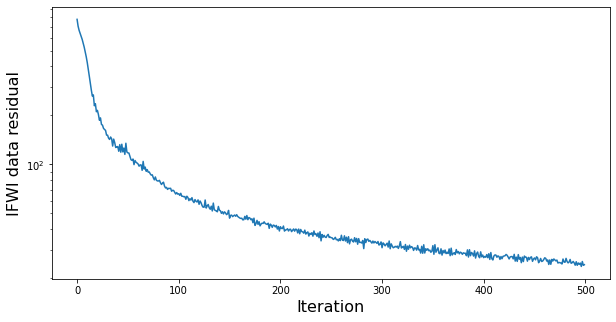

In [13]:
font_size = 16
fig = plt.figure(figsize=(10, 5))
plt.plot(train_loss_history)
plt.yscale("log")
plt.ylabel("IFWI data residual", fontsize=font_size)
plt.xlabel("Iteration", fontsize=font_size)

In [14]:
vmodel1, vmodel2, vmodel3 = model.predict()

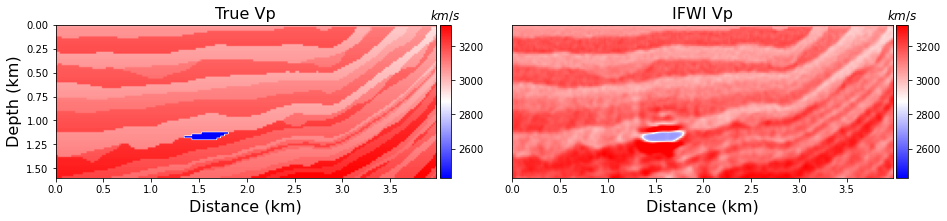

In [15]:
font_size = 16
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title("True Vp", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel1.squeeze().cpu().detach().squeeze(), \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar,vmin=vp_tensor.min(), vmax=vp_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title("IFWI Vp", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

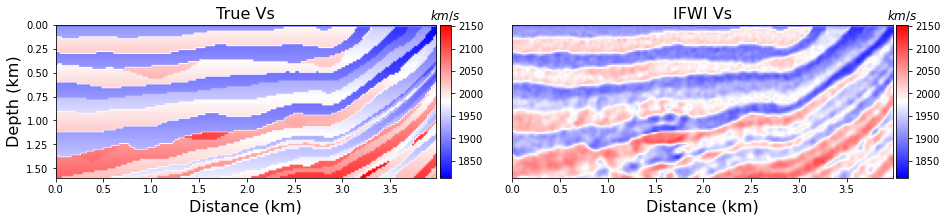

In [16]:
font_size = 16
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title("True Vs", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel2.squeeze().cpu().detach().squeeze(), \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar,vmin=vs_tensor.min(), vmax=vs_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title("IFWI Vs", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

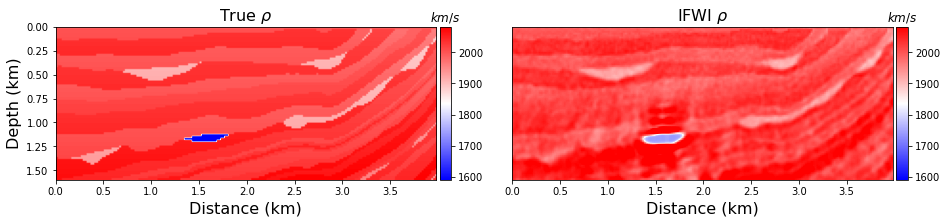

In [17]:
font_size = 16
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar)
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"True $\rho$", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel3.squeeze().cpu().detach().squeeze(), \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap=color_bar,vmin=rho_tensor.min(), vmax=rho_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI $\rho$", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

In [18]:
vmodel1_list = torch.load("./saved_files/vmodel1_list.pt")
vmodel2_list = torch.load("./saved_files/vmodel2_list.pt")
vmodel3_list = torch.load("./saved_files/vmodel3_list.pt")
modle_index_1 = 0
modle_index_2 = 50
modle_index_3 = -1

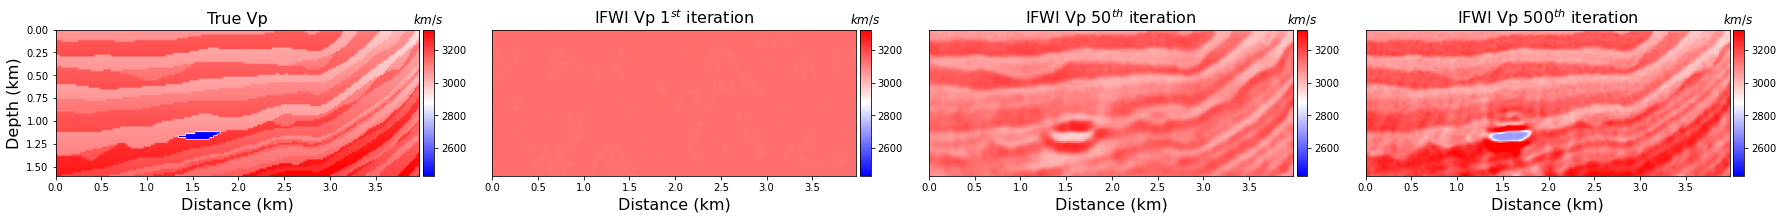

In [66]:
font_size = 16
fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"True Vp", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel1_list[modle_index_1], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vp_tensor.min(), vmax=vp_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vp $1^{st}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(vmodel1_list[modle_index_2], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vp_tensor.min(), vmax=vp_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vp $50^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 3])
im = ax.imshow(vmodel1_list[modle_index_3], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vp_tensor.min(), vmax=vp_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vp $500^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

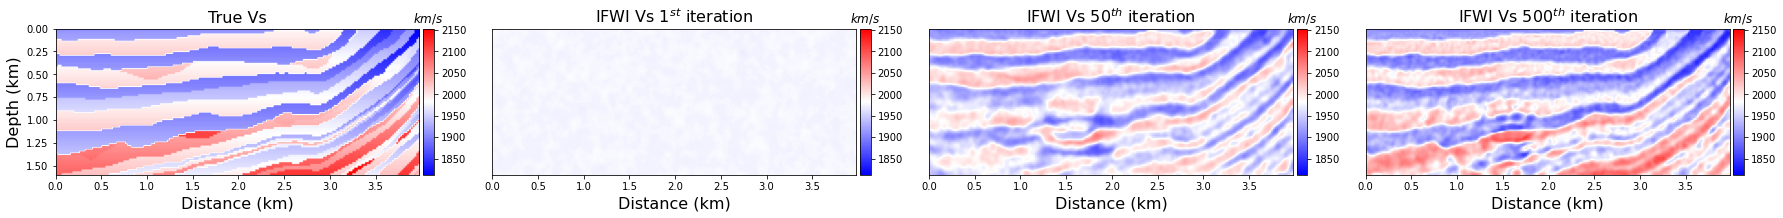

In [67]:
font_size = 16
fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"True Vs", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel2_list[modle_index_1], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vs_tensor.min(), vmax=vs_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vs $1^{st}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(vmodel2_list[modle_index_2], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vs_tensor.min(), vmax=vs_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vs $50^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 3])
im = ax.imshow(vmodel2_list[modle_index_3], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=vs_tensor.min(), vmax=vs_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')
ax.set_title(r"IFWI Vs $500^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

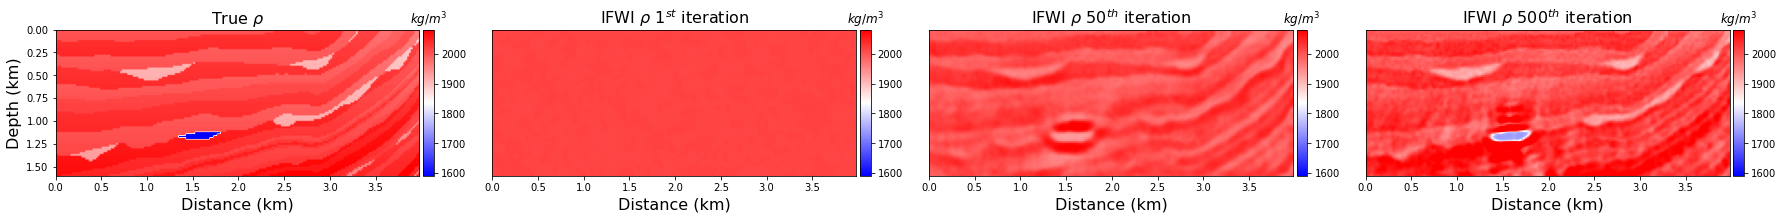

In [68]:
font_size = 16
fig = plt.figure(figsize=(30, 10))
gs = fig.add_gridspec(1, 4)
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')
ax.set_title(r"True $\rho$", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(vmodel3_list[modle_index_1], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=rho_tensor.min(), vmax=rho_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')
ax.set_title(r"IFWI $\rho$ $1^{st}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(vmodel3_list[modle_index_2], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=rho_tensor.min(), vmax=rho_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')
ax.set_title(r"IFWI $\rho$ $50^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 3])
im = ax.imshow(vmodel3_list[modle_index_3], \
               extent=[0, nx*dx0/1000, nz*dz0/1000, 0], aspect=1, cmap='bwr',vmin=rho_tensor.min(), vmax=rho_tensor.max(),)
ax.set_yticks([])
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')
ax.set_title(r"IFWI $\rho$ $500^{th}$ iteration", fontsize=font_size)
ax.set_xlabel("Distance (km)", fontsize=font_size)
#ax.set_ylabel("Depth (km)", fontsize=font_size)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

Text(0.5, 0, 'Depth (m)')

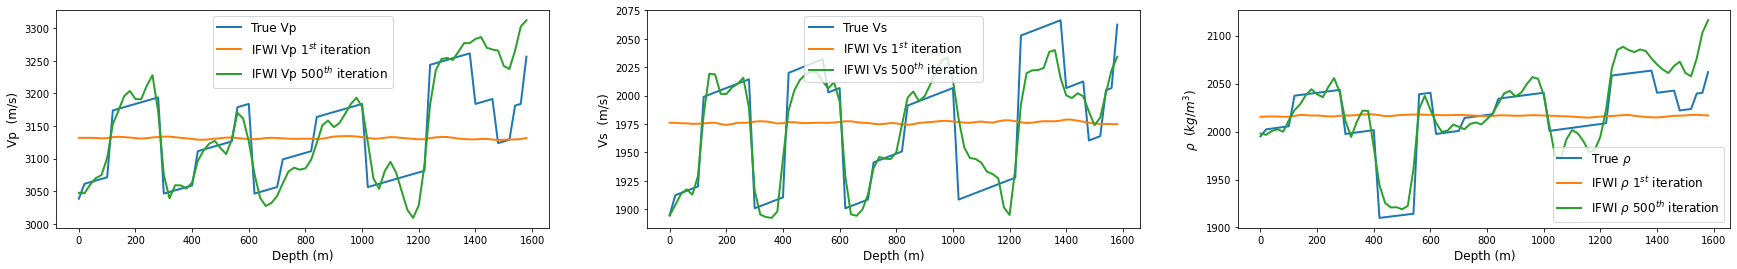

In [70]:
trace_index = 55
vp_true_v_profile = vp_tensor[:,:,trace_index].cpu().detach().squeeze()
vp_IFWI_initi_v_profile = vmodel1_list[0][:,trace_index]
vp_IFWI_final_v_profile = vmodel1_list[-1][:,trace_index]

vs_true_v_profile = vs_tensor[:,:,trace_index].cpu().detach().squeeze()
vs_IFWI_initi_v_profile = vmodel2_list[0][:,trace_index]
vs_IFWI_final_v_profile = vmodel2_list[-1][:,trace_index]

rho_true_v_profile = rho_tensor[:,:,trace_index].cpu().detach().squeeze()
rho_IFWI_initi_v_profile = vmodel3_list[0][:,trace_index]
rho_IFWI_final_v_profile = vmodel3_list[-1][:,trace_index]


depth = np.arange(0, nz, 1, dtype=np.int32)*dz0 # receiver x-coordinate

font_size = 12
fig = plt.figure(figsize=(30, 4))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
plt.plot(depth, vp_true_v_profile, linewidth='2', label='True Vp')
plt.plot(depth, vp_IFWI_initi_v_profile, linewidth='2', label='IFWI Vp $1^{st}$ iteration')
plt.plot(depth, vp_IFWI_final_v_profile, linewidth='2', label='IFWI Vp $500^{th}$ iteration')
plt.legend(fontsize=font_size)
plt.ylabel("Vp  (m/s)", fontsize=font_size)
plt.xlabel("Depth (m)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 1])
plt.plot(depth, vs_true_v_profile, linewidth='2', label='True Vs')
plt.plot(depth, vs_IFWI_initi_v_profile, linewidth='2', label='IFWI Vs $1^{st}$ iteration')
plt.plot(depth, vs_IFWI_final_v_profile, linewidth='2', label='IFWI Vs $500^{th}$ iteration')
plt.legend(fontsize=font_size)
plt.ylabel("Vs  (m/s)", fontsize=font_size)
plt.xlabel("Depth (m)", fontsize=font_size)

ax = fig.add_subplot(gs[0, 2])
plt.plot(depth, rho_true_v_profile, linewidth='2', label=r'True $\rho$')
plt.plot(depth, rho_IFWI_initi_v_profile, linewidth='2', label=r'IFWI $\rho$ $1^{st}$ iteration')
plt.plot(depth, rho_IFWI_final_v_profile, linewidth='2', label=r'IFWI $\rho$ $500^{th}$ iteration')
plt.legend(fontsize=font_size)
plt.ylabel(r"$\rho$  ($kg/m^{3}$)", fontsize=font_size)
plt.xlabel("Depth (m)", fontsize=font_size)